## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.callbacks import ReduceLROnPlateau
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Code Here
    建立你的神經網路
    """
    # input
    input_layer = keras.layers.Input(input_shape)
    
    # hidden
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    # output
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
optimizer_set2 = ['SGD', 'ADAM', 'RMSPROP']
"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience = reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 4s 89us/step - loss: 2.9686 - accuracy: 0.1086 - val_loss: 2.8142 - val_accuracy: 0.1081
Epoch 11/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.9686 - accuracy: 0.1086 - val_loss: 2.8516 - val_accuracy: 0.1082
Epoch 12/25
50000/50000 [==============================] - 5s 97us/step - loss: 2.9693 - accuracy: 0.1092 - val_loss: 2.8834 - val_accuracy: 0.1094
Epoch 13/25
50000/50000 [==============================] - 5s 108us/step - loss: 2.9686 - accuracy: 0.1083 - val_loss: 2.9091 - val_accuracy: 0.1088
Epoch 14/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.9688 - accuracy: 0.1092 - val_loss: 2.9294 - val_accuracy: 0.1089
Epoch 15/25
50000/50000 [==============================] - 5s 96us/step - loss: 2.9702 - accuracy: 0.1087 - val_loss: 2.9443 - val_accuracy: 0.1108
Epoch 16/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.9687 - accuracy: 0.1086 - val_loss: 2.95

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 107us/step - loss: 3.0613 - accuracy: 0.0964 - val_loss: 2.3513 - val_accuracy: 0.1094
Epoch 2/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.0610 - accuracy: 0.0964 - val_loss: 2.3884 - val_accuracy: 0.1100
Epoch 3/25
50000/50000 [==============================] - 6s 110us/step - loss: 3.0601 - accuracy: 0.0969 - val_loss: 2.4489 - val_accuracy: 0.1043
Epoch 4/25
50000/50000 [==============================] - 6s 116us/step - loss: 3.0613 - accuracy: 0.0973 - val_loss: 2.5163 - val_accuracy: 0.1008
Epoch 5/25
50000/50000 [==============================] - 4s 86us/step - loss: 3.0597 - accuracy: 0.0967 - val_loss: 2.5838 - val_accuracy: 0.1021
Epoch 6/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.0618 - accuracy: 0.0968 - val_loss: 2.6496 - val_accuracy: 0.0998
Epoch 7/25
50000/50000 [==============================] - 4s 89us

50000/50000 [==============================] - 8s 160us/step - loss: 3.1790 - accuracy: 0.0789 - val_loss: 3.2033 - val_accuracy: 0.0767
Epoch 21/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.1767 - accuracy: 0.0792 - val_loss: 3.2044 - val_accuracy: 0.0767
Epoch 22/25
50000/50000 [==============================] - 10s 194us/step - loss: 3.1771 - accuracy: 0.0799 - val_loss: 3.2051 - val_accuracy: 0.0766
Epoch 23/25
50000/50000 [==============================] - 10s 200us/step - loss: 3.1781 - accuracy: 0.0795 - val_loss: 3.2057 - val_accuracy: 0.0769
Epoch 24/25
50000/50000 [==============================] - 10s 203us/step - loss: 3.1779 - accuracy: 0.0780 - val_loss: 3.2059 - val_accuracy: 0.0768
Epoch 25/25
50000/50000 [==============================] - 10s 205us/step - loss: 3.1771 - accuracy: 0.0787 - val_loss: 3.2060 - val_accuracy: 0.0768
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
Model: "model_7"
______________________________________

50000/50000 [==============================] - 11s 228us/step - loss: 3.0708 - accuracy: 0.0837 - val_loss: 2.5260 - val_accuracy: 0.0970
Epoch 5/25
50000/50000 [==============================] - 10s 208us/step - loss: 3.0719 - accuracy: 0.0837 - val_loss: 2.5914 - val_accuracy: 0.0940
Epoch 6/25
50000/50000 [==============================] - 10s 207us/step - loss: 3.0725 - accuracy: 0.0826 - val_loss: 2.6585 - val_accuracy: 0.0912
Epoch 7/25
50000/50000 [==============================] - 10s 203us/step - loss: 3.0709 - accuracy: 0.0827 - val_loss: 2.7244 - val_accuracy: 0.0897
Epoch 8/25
50000/50000 [==============================] - 11s 217us/step - loss: 3.0716 - accuracy: 0.0837 - val_loss: 2.7867 - val_accuracy: 0.0875
Epoch 9/25
50000/50000 [==============================] - 7s 144us/step - loss: 3.0710 - accuracy: 0.0835 - val_loss: 2.8425 - val_accuracy: 0.0870
Epoch 10/25
50000/50000 [==============================] - 7s 141us/step - loss: 3.0719 - accuracy: 0.0834 - val_loss:

Epoch 24/25
50000/50000 [==============================] - 10s 191us/step - loss: 3.1013 - accuracy: 0.0834 - val_loss: 3.0721 - val_accuracy: 0.0882
Epoch 25/25
50000/50000 [==============================] - 10s 191us/step - loss: 3.1021 - accuracy: 0.0837 - val_loss: 3.0720 - val_accuracy: 0.0884
Numbers of exp: 8, reduce_factor: 0.00, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________

50000/50000 [==============================] - 4s 86us/step - loss: 3.2137 - accuracy: 0.0765 - val_loss: 2.9327 - val_accuracy: 0.0723
Epoch 9/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.2143 - accuracy: 0.0758 - val_loss: 2.9809 - val_accuracy: 0.0724
Epoch 10/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.2139 - accuracy: 0.0755 - val_loss: 3.0265 - val_accuracy: 0.0729
Epoch 11/25
50000/50000 [==============================] - 5s 91us/step - loss: 3.2137 - accuracy: 0.0766 - val_loss: 3.0678 - val_accuracy: 0.0746
Epoch 12/25
50000/50000 [==============================] - 5s 96us/step - loss: 3.2132 - accuracy: 0.0760 - val_loss: 3.1044 - val_accuracy: 0.0740
Epoch 13/25
50000/50000 [==============================] - 5s 102us/step - loss: 3.2140 - accuracy: 0.0756 - val_loss: 3.1348 - val_accuracy: 0.0742
Epoch 14/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.2133 - accuracy: 0.0757 - val_loss: 3.1589

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.2280 - accuracy: 0.0808 - val_loss: 2.3477 - val_accuracy: 0.0954
Epoch 2/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.2269 - accuracy: 0.0800 - val_loss: 2.4043 - val_accuracy: 0.0989
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.2277 - accuracy: 0.0804 - val_loss: 2.4728 - val_accuracy: 0.1020
Epoch 4/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.2284 - accuracy: 0.0801 - val_loss: 2.5496 - val_accuracy: 0.0992
Epoch 5/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.2272 - accuracy: 0.0797 - val_loss: 2.6321 - val_accuracy: 0.0971
Epoch 6/25
50000/50000 [==============================] - 5s 91us/step - loss: 3.2282 - accuracy: 0.0796 - val_loss: 2.7165 - val_accuracy: 0.0926
Epoch 7/25
50000/50000 [==============================] - 4s 88us/s

Epoch 21/25
50000/50000 [==============================] - 5s 97us/step - loss: 3.0816 - accuracy: 0.0976 - val_loss: 3.1024 - val_accuracy: 0.0980
Epoch 22/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.0825 - accuracy: 0.0964 - val_loss: 3.1029 - val_accuracy: 0.0979
Epoch 23/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.0823 - accuracy: 0.0969 - val_loss: 3.1034 - val_accuracy: 0.0979
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.0823 - accuracy: 0.0970 - val_loss: 3.1037 - val_accuracy: 0.0981
Epoch 25/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.0808 - accuracy: 0.0969 - val_loss: 3.1043 - val_accuracy: 0.0981
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 20
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)         

Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.9274 - accuracy: 0.1121 - val_loss: 2.5445 - val_accuracy: 0.1214
Epoch 7/25
50000/50000 [==============================] - 5s 90us/step - loss: 2.9283 - accuracy: 0.1119 - val_loss: 2.5990 - val_accuracy: 0.1194
Epoch 8/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.9287 - accuracy: 0.1119 - val_loss: 2.6541 - val_accuracy: 0.1176
Epoch 9/25
50000/50000 [==============================] - 5s 90us/step - loss: 2.9271 - accuracy: 0.1123 - val_loss: 2.7062 - val_accuracy: 0.1158
Epoch 10/25
50000/50000 [==============================] - 5s 90us/step - loss: 2.9276 - accuracy: 0.1114 - val_loss: 2.7528 - val_accuracy: 0.1151
Epoch 11/25
50000/50000 [==============================] - 5s 90us/step - loss: 2.9276 - accuracy: 0.1112 - val_loss: 2.7934 - val_accuracy: 0.1140
Epoch 12/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.9278 - accuracy: 0.1123 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.8052 - accuracy: 0.3720 - val_loss: 2.7142 - val_accuracy: 0.1986
Epoch 2/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.5494 - accuracy: 0.4526 - val_loss: 2.6606 - val_accuracy: 0.1960
Epoch 3/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4331 - accuracy: 0.4946 - val_loss: 1.9805 - val_accuracy: 0.3318
Epoch 4/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.3599 - accuracy: 0.5200 - val_loss: 1.9269 - val_accuracy: 0.3182
Epoch 5/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.2947 - accuracy: 0.5451 - val_loss: 2.4769 - val_accuracy: 0.2703
Epoch 6/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.2431 - accuracy: 0.5603 - val_loss: 1.8151 - val_accuracy: 0.3760
Epoch 7/25
50000/50000 [==============================] - 4s 84us/s

50000/50000 [==============================] - 4s 86us/step - loss: 3.1258 - accuracy: 0.0829 - val_loss: 3.1212 - val_accuracy: 0.0835
Epoch 21/25
50000/50000 [==============================] - 4s 84us/step - loss: 3.1252 - accuracy: 0.0831 - val_loss: 3.1222 - val_accuracy: 0.0832
Epoch 22/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.1254 - accuracy: 0.0826 - val_loss: 3.1231 - val_accuracy: 0.0832
Epoch 23/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.1267 - accuracy: 0.0826 - val_loss: 3.1237 - val_accuracy: 0.0831
Epoch 24/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.1256 - accuracy: 0.0825 - val_loss: 3.1236 - val_accuracy: 0.0831
Epoch 25/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.1259 - accuracy: 0.0824 - val_loss: 3.1238 - val_accuracy: 0.0831
Numbers of exp: 18, reduce_factor: 0.25, reduce_patient: 5
Model: "model_20"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.9669 - accuracy: 0.1147 - val_loss: 2.5874 - val_accuracy: 0.1007
Epoch 6/25
50000/50000 [==============================] - 5s 95us/step - loss: 2.9669 - accuracy: 0.1143 - val_loss: 2.6422 - val_accuracy: 0.1012
Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 2.9674 - accuracy: 0.1144 - val_loss: 2.6932 - val_accuracy: 0.1039
Epoch 8/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.9662 - accuracy: 0.1138 - val_loss: 2.7412 - val_accuracy: 0.1061
Epoch 9/25
50000/50000 [==============================] - 5s 97us/step - loss: 2.9673 - accuracy: 0.1140 - val_loss: 2.7854 - val_accuracy: 0.1069
Epoch 10/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.9670 - accuracy: 0.1153 - val_loss: 2.8252 - val_accuracy: 0.1076
Epoch 11/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.9672 - accuracy: 0.1147 - val_l

Epoch 25/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.9893 - accuracy: 0.1073 - val_loss: 3.0079 - val_accuracy: 0.1034
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 20
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
_______________________________________________

Epoch 10/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.0835 - accuracy: 0.0961 - val_loss: 2.9223 - val_accuracy: 0.0944
Epoch 11/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.0837 - accuracy: 0.0967 - val_loss: 2.9681 - val_accuracy: 0.0948
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 3.0832 - accuracy: 0.0965 - val_loss: 3.0044 - val_accuracy: 0.0946
Epoch 13/25
50000/50000 [==============================] - 5s 92us/step - loss: 3.0831 - accuracy: 0.0966 - val_loss: 3.0325 - val_accuracy: 0.0945
Epoch 14/25
50000/50000 [==============================] - 4s 89us/step - loss: 3.0824 - accuracy: 0.0965 - val_loss: 3.0537 - val_accuracy: 0.0963
Epoch 15/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0829 - accuracy: 0.0972 - val_loss: 3.0693 - val_accuracy: 0.0967
Epoch 16/25
50000/50000 [==============================] - 5s 91us/step - loss: 3.0825 - accuracy: 0.0967 - val_

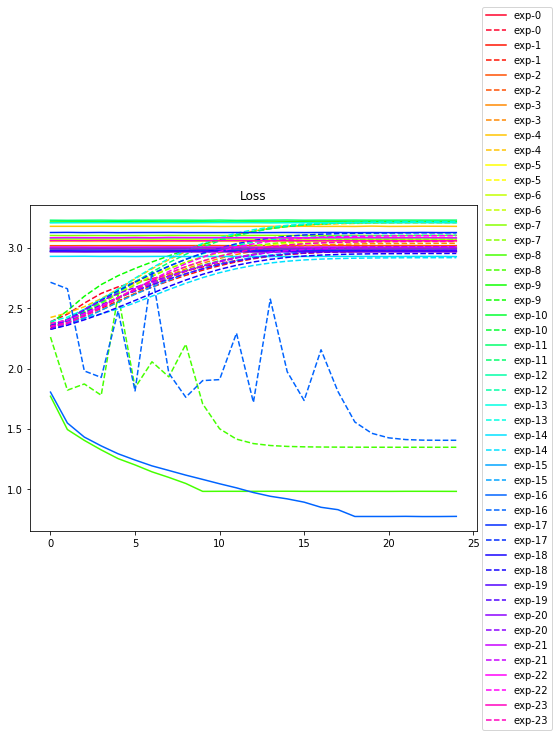

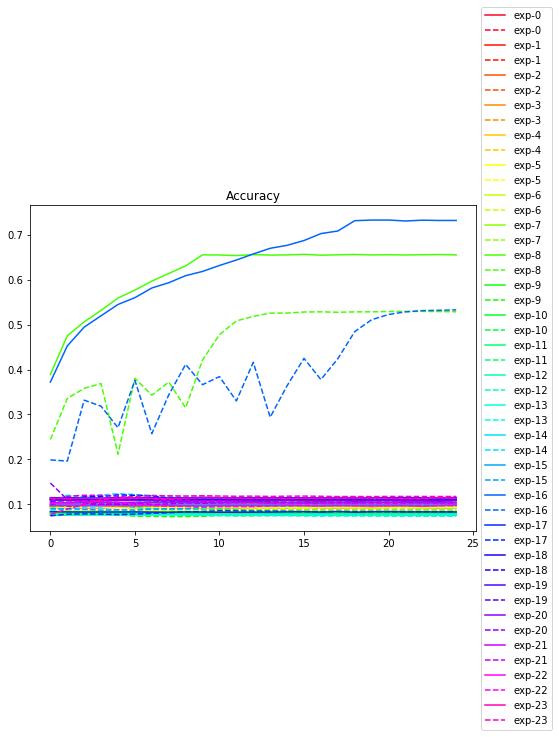

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()